# Import Libraries

In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
from torch import nn, optim
import torch.nn.functional as F

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.manifold import TSNE

import seaborn as sns

# Data Import and Preprocessing

### Define Transform

In [2]:
tensor = transforms.ToTensor()
normalize = transforms.Normalize((0.5,), (0.5,))
transformation = transforms.Compose([tensor, normalize])

### Import Data

In [3]:
training_dataset = datasets.MNIST('./dataset_q3',  train=True, transform=transformation)
testing_dataset = datasets.MNIST('./dataset_q3',  train=False, transform=transformation)

# Create Data Loader
train_data = torch.utils.data.DataLoader(training_dataset, batch_size=64, shuffle=True)
test_data = torch.utils.data.DataLoader(testing_dataset, batch_size=64, shuffle=True)

In [16]:
# Correct to include all 10000 examples
train_features = []
train_labels = []
for features, labels in train_data:
    train_features.append(features.view(-1, 28*28).numpy())
    train_labels.append(labels.numpy())

train_features = np.concatenate(train_features, axis=0)
train_labels = np.concatenate(train_labels, axis=0)

test_features = []
test_labels = []
for features, labels in test_data:
    test_features.append(features.view(-1, 28*28).numpy())
    test_labels.append(labels.numpy())

test_features = np.concatenate(test_features, axis=0)
test_labels = np.concatenate(test_labels, axis=0)

In [5]:
print("Length of train features: ", len(train_features))    
print("Length of train labels: ", len(train_labels))
print("Length of test features: ", len(test_features))
print("Length of test labels: ", len(test_labels))

Length of train features:  60000
Length of train labels:  60000
Length of test features:  10000
Length of test labels:  10000


### Sample Images in the Dataset

<Figure size 4000x4000 with 0 Axes>

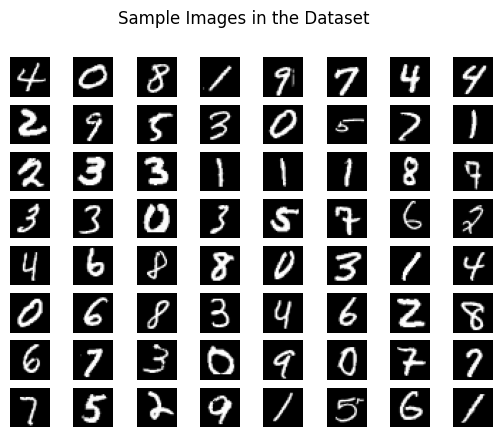

In [6]:
images, labels = next(iter(train_data))
plt.figure(figsize=(40, 40))
fig, ax = plt.subplots()
for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.imshow(images[i].numpy().squeeze(), cmap='gray')
    plt.axis('off')
fig.delaxes(ax)
plt.suptitle("Sample Images in the Dataset")
plt.show()

# Train the Model

### Define Model Architecture

In [7]:
class MLP(nn.Module):  # 3 Layer MLP with 30 neurons in the first layer, 20 in second and 10 in the output layer
    def __init__(self):
        super(MLP,self).__init__()
        self.fc1 = nn.Linear(28*28,30)
        self.fc2 = nn.Linear(30,20)
        self.fc3 = nn.Linear(20,10)
        
    def forward(self,x):
        x = x.view(-1,28*28)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def get_activations(self,x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        return torch.relu(self.fc2(x))

In [8]:
model = MLP()
untrained_model = copy.deepcopy(model)   # For getting t-sne of activations of untrained model
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
epochs = 50
losses = []

### Outputs of the Untrained Model

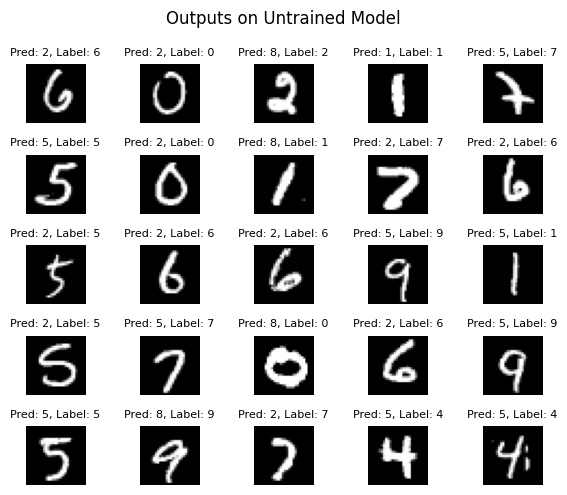

In [9]:
test_image, test_labels = next(iter(test_data))
fig, ax = plt.subplots(figsize=(6, 5))  

for i in range(25):
    pred = np.argmax(model(test_image[i].view(-1, 28*28)).detach().numpy())
    plt.subplot(5, 5, i+1)
    plt.imshow(test_image[i].numpy().squeeze(), cmap='gray')
    plt.title(f'Pred: {pred}, Label: {test_labels[i].numpy()}', fontsize=8)  
    plt.axis('off')  

plt.suptitle("Outputs on Untrained Model")
fig.delaxes(ax)
plt.tight_layout()
plt.show()


### Training the model for 50 epochs

In [10]:
total = 0
losses = [] 
for e in range(epochs):
    for image, label in train_data:
        total += len(image)  
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())  
    print(f"Epoch: {e+1} Loss: {loss.item()}")
print(f"Total Images = {total/epochs}")

Epoch: 1 Loss: 0.7843237519264221
Epoch: 2 Loss: 0.4867739975452423
Epoch: 3 Loss: 0.0841449499130249
Epoch: 4 Loss: 0.2338368147611618
Epoch: 5 Loss: 0.20266547799110413
Epoch: 6 Loss: 0.3859972357749939
Epoch: 7 Loss: 0.4149903953075409
Epoch: 8 Loss: 0.282361775636673
Epoch: 9 Loss: 0.1570943146944046
Epoch: 10 Loss: 0.14939716458320618
Epoch: 11 Loss: 0.14719709753990173
Epoch: 12 Loss: 0.13085517287254333
Epoch: 13 Loss: 0.1649719476699829
Epoch: 14 Loss: 0.2999274730682373
Epoch: 15 Loss: 0.11183404177427292
Epoch: 16 Loss: 0.19861364364624023
Epoch: 17 Loss: 0.24851591885089874
Epoch: 18 Loss: 0.1503458321094513
Epoch: 19 Loss: 0.05442792922258377
Epoch: 20 Loss: 0.014411576092243195
Epoch: 21 Loss: 0.07216104120016098
Epoch: 22 Loss: 0.04609595239162445
Epoch: 23 Loss: 0.07111616432666779
Epoch: 24 Loss: 0.10742764919996262
Epoch: 25 Loss: 0.044820111244916916
Epoch: 26 Loss: 0.08665479719638824
Epoch: 27 Loss: 0.4765731692314148
Epoch: 28 Loss: 0.1456095427274704
Epoch: 29 Los

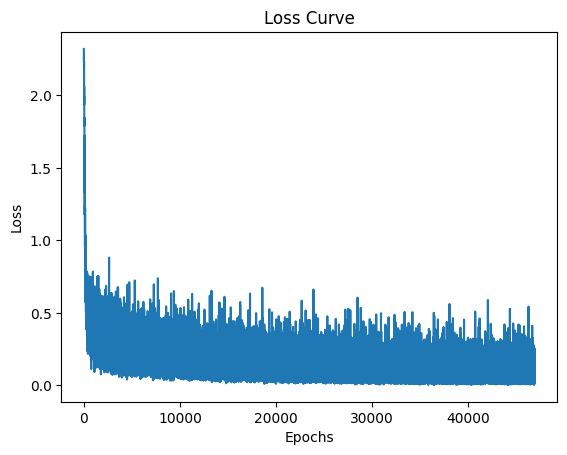

In [11]:
plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.show()

### Sample outputs of the Trained Model

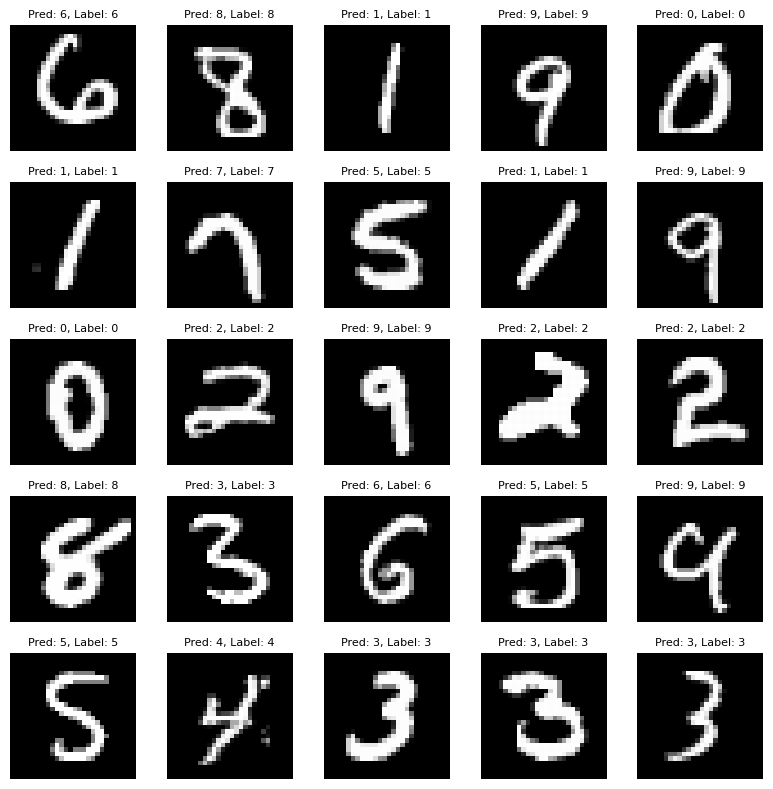

In [12]:
sample_test_image, sample_test_labels = next(iter(test_data))
fig, ax = plt.subplots(figsize=(8, 8))  
for i in range(25):
    pred = np.argmax(model(sample_test_image[i].view(-1, 28*28)).detach().numpy())
    plt.subplot(5, 5, i+1)
    plt.imshow(sample_test_image[i].numpy().squeeze(), cmap='gray')
    plt.title(f'Pred: {pred}, Label: {sample_test_labels[i].numpy()}', fontsize=8)  
    plt.axis('off')  
fig.delaxes(ax)
plt.tight_layout()
plt.show()

In [13]:
total = 0 
y_pred = []
y_true = []
for image, label in test_data:
    total += len(image)  
    for i in range(len(image)):
        with torch.no_grad():
            output = model(image[i].view(-1, 28*28))
        y = np.argmax(output, axis=1)
        y_pred.append(y)
        y_true.append(label[i])
y_pred=np.array(y_pred).flatten()
y_true=np.array(y_true)
print(f"Shape of y_pred = {y_pred.shape}")
print(f"Shape of y_pred = {y_true.shape}")

Shape of y_pred = (10000,)
Shape of y_pred = (10000,)


### Metrics of the Trained MLP

In [14]:
accuracy = ((y_pred == y_true).sum()) / total * 100
print(f"Accuracy: {accuracy} %")
print(f"F1 Score: {f1_score(y_true, y_pred, average='macro')}")
cm_mlp = confusion_matrix(y_true, y_pred)
print("Confusion Matrix: ")
print(cm_mlp)

Accuracy: 95.48 %
F1 Score: 0.9542317521703787
Confusion Matrix: 
[[ 958    0    1    1    0    7    4    3    2    4]
 [   1 1111    1    3    0    1    3    4   10    1]
 [   8    2  979   13    3    2    3    9   13    0]
 [   1    0    5  940    2   43    1    7    6    5]
 [   0    0    5    1  919    4    4    5    8   36]
 [   5    1    0    4    2  865    6    3    4    2]
 [   6    3    2    0    6   23  911    0    7    0]
 [   0    2    5   11    1    2    0  988    7   12]
 [   5    1    0   12    6   23    3    7  914    3]
 [   2    2    0    8    8   11    1    7    7  963]]


### Random Forest Classifier

In [18]:
rf = RandomForestClassifier() # Random Forest Classifier from sklearn
rf.fit(train_features, train_labels)
y_pred = rf.predict(test_features)
accuracy = accuracy_score(test_labels, y_pred)
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1_score(test_labels, y_pred, average='macro')}")
cm_rf = confusion_matrix(test_labels, y_pred)
print(cm_rf)

Accuracy: 0.9701
F1 Score: 0.969897950155971
[[ 970    0    0    1    0    2    2    2    3    0]
 [   0 1124    2    3    0    1    3    0    1    1]
 [   8    0  997    4    3    0    4   10    6    0]
 [   0    0    8  975    0    5    0    9   10    3]
 [   1    0    1    0  954    0    5    0    2   19]
 [   2    1    0   11    3  860    6    3    4    2]
 [   8    3    0    0    3    4  938    0    2    0]
 [   1    2   22    0    0    0    0  990    2   11]
 [   4    0    4    8    5    5    5    3  931    9]
 [   6    5    2   10   11    1    1    3    8  962]]


### Logistic Regression

In [19]:
logistic = LogisticRegression(max_iter=1000)
logistic.fit(train_features, train_labels)
y_pred = logistic.predict(test_features)
accuracy = accuracy_score(test_labels, y_pred)
print(f"Accuracy: {accuracy*100} %")
print(f"F1 Score: {f1_score(test_labels, y_pred, average='macro')}")
cm_lr = confusion_matrix(test_labels, y_pred)
print(cm_lr)

Accuracy: 92.54 %
F1 Score: 0.9244140419439976
[[ 954    0    2    3    1   10    4    3    3    0]
 [   0 1110    6    2    0    2    3    1   11    0]
 [   7   10  926   18   11    3   12    8   34    3]
 [   4    1   19  921    2   22    2   10   22    7]
 [   1    4    7    4  921    0    7    6    6   26]
 [   9    4    3   36    9  777   13    6   31    4]
 [   9    3    7    2    5   16  914    1    1    0]
 [   1    7   23    8    6    1    0  946    4   32]
 [   8   12    7   22    8   23   10   10  862   12]
 [   8    7    2    9   22    7    0   21   10  923]]


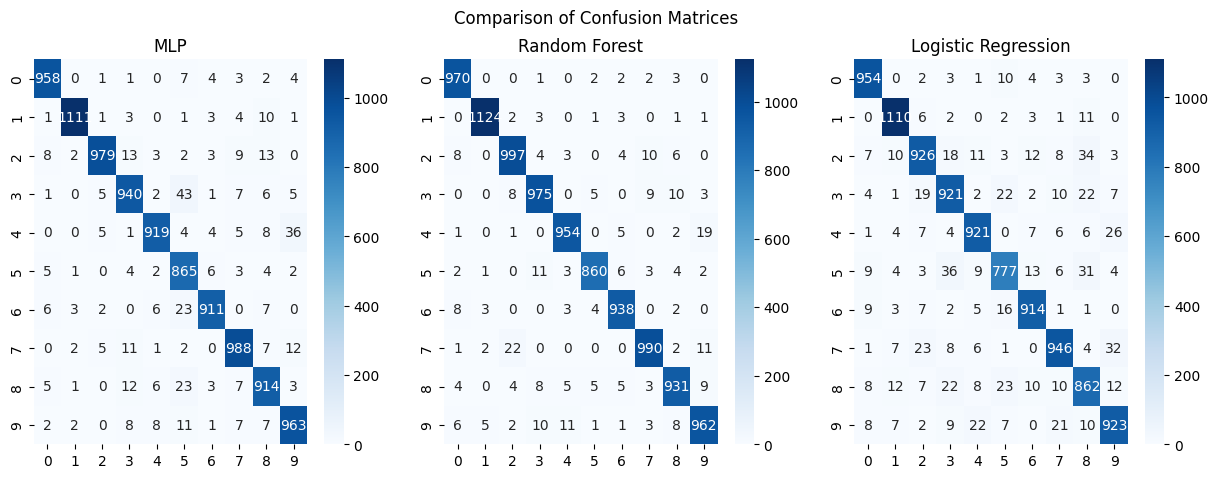

In [20]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.heatmap(cm_mlp, annot=True, fmt='d', ax=ax[0], cmap='Blues')
ax[0].set_title("MLP")
sns.heatmap(cm_rf, annot=True, fmt='d', ax=ax[1], cmap='Blues')
ax[1].set_title("Random Forest")
sns.heatmap(cm_lr, annot=True, fmt='d', ax=ax[2], cmap='Blues')
ax[2].set_title("Logistic Regression")
fig.suptitle('Comparison of Confusion Matrices')
plt.show()

| Model    | Accuracy | F1-Score|
| -------- | -------- | ------- |
| MLP  | 97.74 %     | 0.9771        |
| Random Forest | 97.12 %      | 0.9710        |
| Logistic   | 92.4 %     |   0.9229      |

### Observations:
- Multi-Layer Perceptron (MLP) has the highest percentage of accuracy, followed by Random Forest Classifier followed by Logistic Regression
- The same trend is also true for the F1-Score also.
- The digit 1 is most accuractely classified by all the models.

### Commonly Confused Digits:
From the confusion matrix of the three models, we can see that:
- 1 and 2 are confused. This may be possible because of writing two in a narrow way or 1 in different style than a straight line.
- 3 ans 8 are confused. This may be possible as both the numbers have similar semantics.
- 4 and 9 are confused. This may be possible as both the numbers have similar semantics.
- 7 ans 1 are confused. This may be possible because of the horizontal line of 7 being short.
- 7 ans 2 are confused. This may be possible because of similar semantics.
- 7 and 9 are confused. This may be possible because of similar semantics.

## Comparing the t-SNE of the Trained and Untrained Model

In [21]:
def extract_features(model, loader):
    activation = []
    label = []
    model.eval()
    with torch.no_grad():
        for images, labels in loader:
            activations = model.get_activations(images)
            activation.append(activations)
            label.append(labels)
    activation = torch.cat(activation).numpy()
    label = torch.cat(label).numpy()
    return activation, label

In [22]:
untrained_activations, _ = extract_features(untrained_model, test_data)
trained_activations, y_true = extract_features(model, test_data)
print(f"Shape of untrained activations = {untrained_activations.shape}")
print(f"Shape of trained activations = {trained_activations.shape}")

tsne_untrained = TSNE(n_components=2).fit_transform(untrained_activations)
tsne_trained = TSNE(n_components=2).fit_transform(trained_activations)

Shape of untrained activations = (10000, 20)
Shape of trained activations = (10000, 20)


c:\Users\Harshil Shah\python310\Lib\site-packages\threadpoolctl.py:1186: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


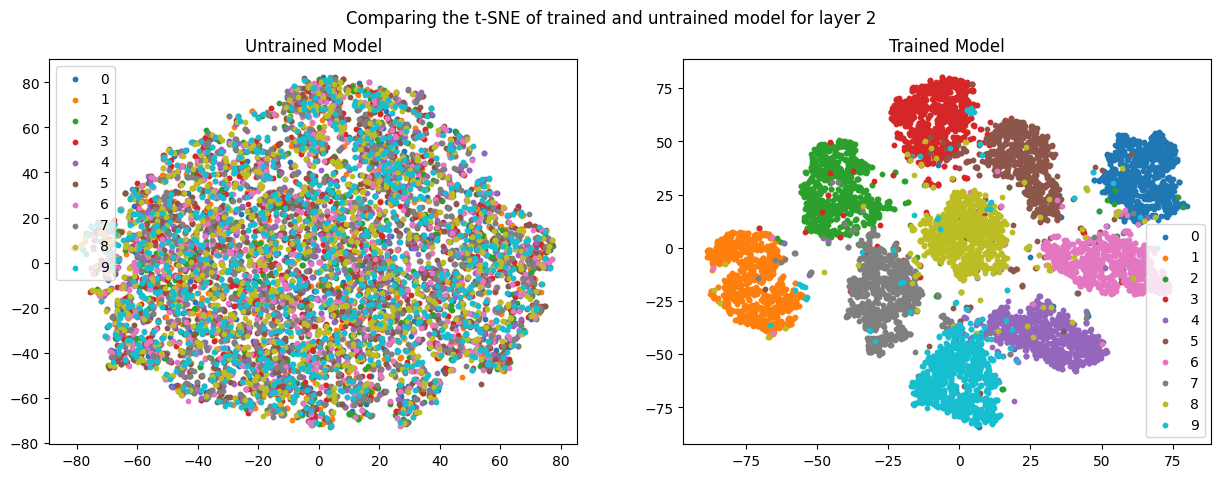

In [25]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
for i in range(10):
    plt.scatter(tsne_untrained[y_true == i, 0], tsne_untrained[y_true == i, 1], s=10, label=i)
plt.title('Untrained Model')
plt.legend()
plt.subplot(1, 2, 2)
for i in range(10):
    plt.scatter(tsne_trained[y_true == i, 0], tsne_trained[y_true == i, 1], s=10, label=i)
plt.legend()
plt.title('Trained Model')
plt.suptitle('Comparing the t-SNE of trained and untrained model for layer 2')
plt.show()

### Conclusion:
By observing the t-SNE plots for the trained and the untrained model, we can observe that the model has learnt the decision boundaries between the different number classes and has made them into different clusters. Therefore, we can conclude that the model is able to learn the digits well. Moreover, clusters of similar looking digits are closer to each other suggesting that model is able to identify semantics of the digits.

## Task 2:  Fashion-MNIST Dataset

### Loading Data

In [24]:
fashion_mnist_test = datasets.FashionMNIST('./Dataset_Q3', train=False, transform=transformation)
fashion_data = torch.utils.data.DataLoader(fashion_mnist_test, batch_size=64, shuffle=True)

### Sample Images from the Fashion-MNIST Dataset

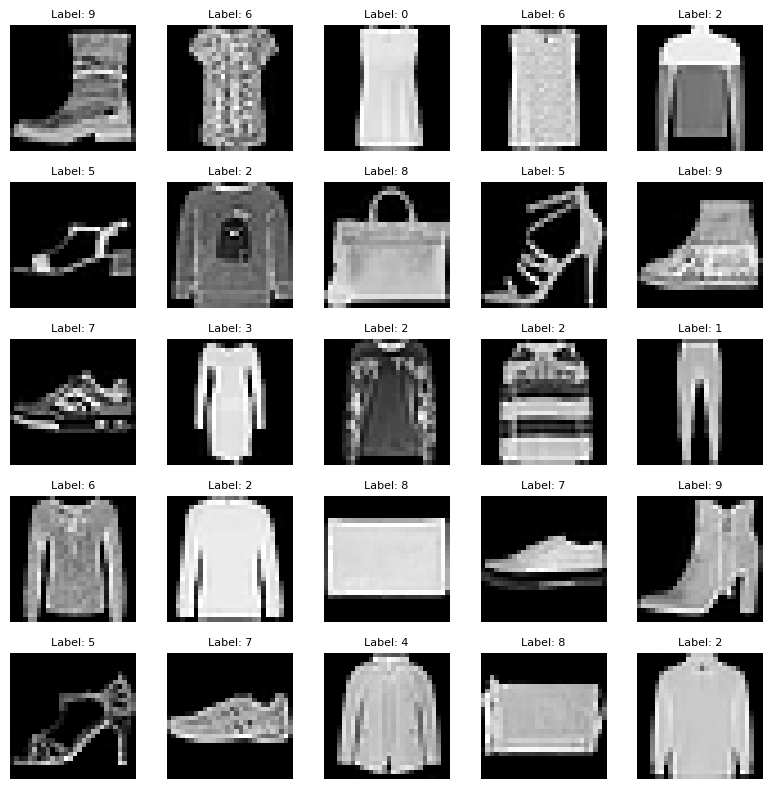

In [26]:
images, labels = next(iter(fashion_data))
fig, ax = plt.subplots(figsize=(8, 8))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(images[i].numpy().squeeze(), cmap='gray')
    plt.title(f'Label: {labels[i].numpy()}', fontsize=8)
    plt.axis('off')
fig.delaxes(ax)
plt.tight_layout()
plt.show()

### Predicting output of MNIST moddel on Fashion-MNIST

In [27]:
y_pred_fashion = []
y_true_fashion = []
for image, label in fashion_data:
    total += len(image)  
    for i in range(len(image)):
        with torch.no_grad():
            output = model(image[i].view(-1, 28*28))
        y = np.argmax(output, axis=1)
        y_pred_fashion.append(y)
        y_true_fashion.append(label[i])
y_pred_fashion=np.array(y_pred_fashion).flatten()
y_true_fashion=np.array(y_true_fashion)
print(f"Shape of y_pred_fashion = {y_pred_fashion.shape}")
print(f"Shape of y_true_fashion = {y_true_fashion.shape}")

Shape of y_pred_fashion = (10000,)
Shape of y_true_fashion = (10000,)


Accuracy: 3.0300000000000002 %
F1 Score: 0.04562451796132598


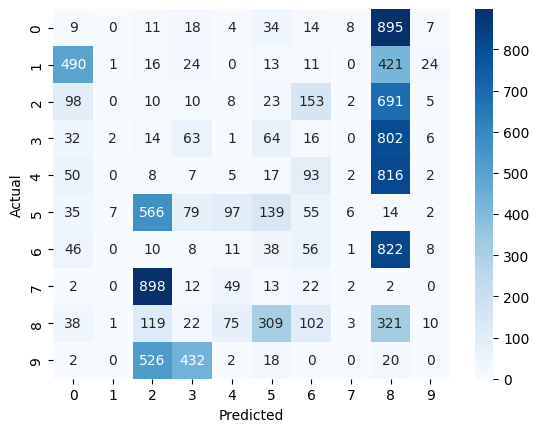

In [28]:
accuracy = ((y_pred_fashion == y_true_fashion).sum()) / total * 100
print(f"Accuracy: {accuracy} %")
print(f"F1 Score: {f1_score(y_true_fashion, y_pred_fashion, average='macro')}")
cm = confusion_matrix(y_true_fashion, y_pred_fashion)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Visualising the t-SNE for the Fashion Model and the Trained Model

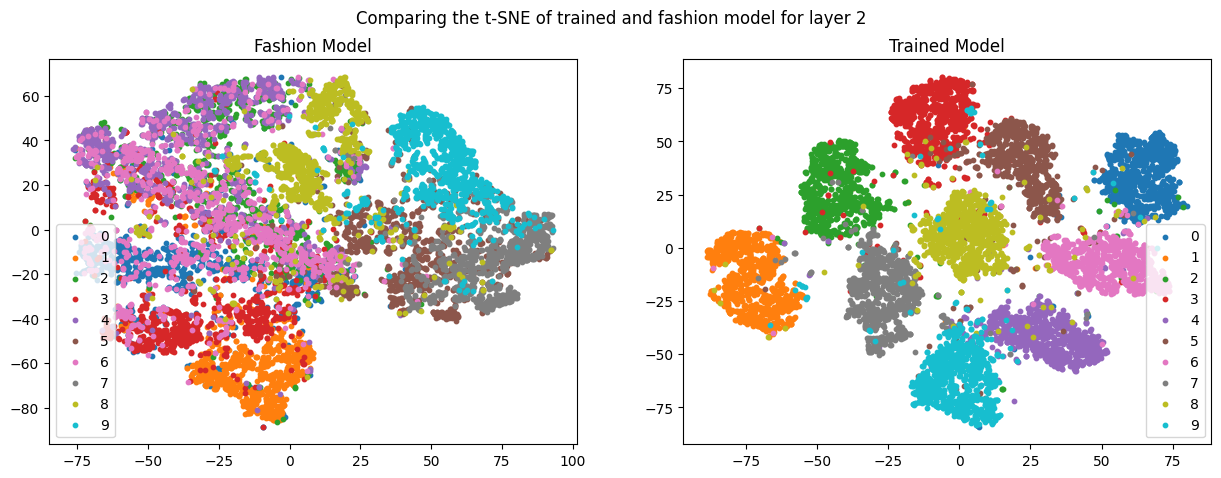

In [30]:
fashion_activations, y_fashion = extract_features(model, fashion_data)
tsne_fashion = TSNE(n_components=2).fit_transform(fashion_activations)
print(tsne_trained.shape, tsne_fashion.shape)
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
for i in range(10):
    plt.scatter(tsne_fashion[y_fashion == i, 0], tsne_fashion[y_fashion == i, 1], s=10, label=i)
plt.legend()
plt.title('Fashion Model')
plt.subplot(1, 2, 2)
for i in range(10):
    plt.scatter(tsne_trained[y_true == i, 0], tsne_trained[y_true == i, 1], s=10, label=i)
plt.legend()
plt.title('Trained Model')
plt.suptitle("Comparing the t-SNE of trained and fashion model for layer 2")
plt.show()

### Observations:
- The accuracy and F1-Score of the model is very low. This is because the Fashion-MNIST Dataset contains images of fashion items like shoes, t-shirts etc. while the model is trained on MNIST dataset, which contains digits. Therefore, as the model has learned only on the digits, it is not not surprising that it will not be able to classify the fashion items incorrectly.

- From the t-SNE graph of the Fashion-MNIST, we can see that is is highly confused than the trained model. Though, it is seperated some things into some diffused clusters, which is evident from the confusion matrix also, it is not able to get a clear decision boundary for all the classes.